# DataFabrikken Hackathon
Welcome to the Hackathon! This Jupyter Python-notebook can help you getting started with the datasets provided.

## Municipalities' Energy Datasets

The datasets are based on municipality source data.

There are four types of datasets that are connected:
- Location: Describes a location (usually a building) that we have energy data for.
- Measurement point: Describes a measurement point with a unique ID, what the measurement point is, and the unit of measurement.
- LocationMeasurementPoint: Connects a measurement point to a location and gives a local name for the measurement point. Some measurement points are used by several locations, for instance units for temperature measurement from public measurement stations from The Metheorological Institute (met.no)
- Measurements: Timestamped measurement value from a measurement point.

#### The descriptions of the individual datasets are shown below.

### Location
| Feltnavn | Beskrivelse  |
| -------- | ------------ |
| location | Navn på lokasjonen, f.eks. navn på skole eller barnehage |
| municipality_code | Kommunekoden for lokasjonen. Kodene er definert i datasettet [Standard for kommuneinndeling](https://www.ssb.no/klass/klassifikasjoner/131/koder) hos SSB. |
| location_type | Type lokasjon. Lovlige verdier: Bygning, Rom, Annet |
| building_type | Type bygning. Lovlige verdier: Skole, Barnehage, Helsebygg, Administrasjonsbygg, Idrettsbygg, Kirkelig bygg, Beredskapsbygg, Bydels- og fritidsbygg, Kulturbygg, Varmesentral, Annet bygg |
| address | Adresse til lokasjonen / bygget |
| latitude | Breddegrad for lokasjonen i desimalgrader |
| longitude | Lengdegrad for lokasjonen i desimalgrader |
 
### MeasurementPoint
| Feltnavn | Beskrivelse  |
| -------- | ------------ |
| meter_id | Unik id for målepunktet. Eksempler: EID_972418013_00290, Eklima_82290_TAM |
| meter_type | Beskriver hva slags type målepunkt det er. Eksempler er Fastkraft, Temperatur, Graddager, Varmepumpe |
| unit | Enhet som måleren måler, f.eks. kWh, °C |
| meter_level | Vanligvis en av følgende to verdier: Forbruksmåler, Annen måler |
 
### LocationMeasurementPoint
| Feltnavn | Beskrivelse  |
| -------- | ------------ |
| location | Navn på lokasjonen (se Location) |
| municipality_code | Kommunekoden for lokasjonen |
| meter_id | Unik id for målepunktet (se MeasurementPoint) |
| meter_name | Lokalt navn for målepunktet (unikt bare innenfor lokasjonen). Eksempler: Temp middel, Fastkraft, Fastkraft 67756 |
 
### Measurements
| Feltnavn | Beskrivelse  |
| -------- | ------------ |
| timestamp | Tidsstempel med dato og klokkeslett, f.eks. 2010-01-04 06:00:00 |
| meter_id | Unik id for målepunkt (se MeasurementPoint) |
| value | Måleravlesning. Vanligvis flyttall med komma som separator, f.eks. 4,20 |

## The following datasets are available for download:

#### open-municipal-data/source-data/bodo/
- 00 - Bygg og GPS.xlsx
- 42 - Forbruksanalyse-Bodø Kommune - Tverlandet Bo og Servicesenter.csv
- 54 - Forbruksanalyse-Bodø Kommune - Asphaugen barnehage 2.csv
- 78 - Forbruksanalyse-Bodø Kommune - Bankgata Flerbrukshall.csv
- 84 - Forbruksanalyse-Bodø Kommune - Hunstad ungdomsskole.csv

### open-municipal-data/source-data/drammen/
- Energiattest Gulskogen skole.pdf
- Energiattest Åskollen bo og servisesenter.pdf
- Gulskogen skole.csv
- Parktunet barnehage.csv
- Åskollen bo og servisesenter.csv

### open-municipal-data/source-data/stavanger/
- measurement_stavanger.csv

# Locations
- location_measurement_points_bodo.csv <b><a href="https://datafabrikken-v2-api.azurewebsites.net/datasets/location_measurement_points_bodo.csv">Download dataset</a></b>
- location_measurement_points_drammen.csv <b><a href="https://datafabrikken-v2-api.azurewebsites.net/datasets/location_measurement_points_drammen.csv">Download dataset</a></b>
- locations_bodo.csv <b><a href="https://datafabrikken-v2-api.azurewebsites.net/datasets/locations_bodo.csv">Download dataset</a></b>
- locations_drammen.csv <b><a href="https://datafabrikken-v2-api.azurewebsites.net/datasets/locations_drammen.csv">Download dataset</a></b>
- locations_stavanger.csv <b><a href="https://datafabrikken-v2-api.azurewebsites.net/datasets/locations_stavanger.csv">Download dataset</a></b>

# Measurements
- measurement_points_bodo.csv <b><a href="https://datafabrikken-v2-api.azurewebsites.net/datasets/measurement_points_bodo.csv">Download dataset</a></b>
- measurement_points_drammen.csv <b><a href="https://datafabrikken-v2-api.azurewebsites.net/datasets/measurement_points_drammen.csv">Download dataset</a></b>

In [125]:
# Import some libraries

from __future__ import annotations

from typing import Any, Dict, List, Tuple, Iterator, Optional

import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import csv
import os
import time
import re
from datetime import datetime
import math
import json
import timeit
import requests
import jsonschema
from jsonschema import validate
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from os.path import exists
import io
import time
import yaml
import urllib3
from urllib.parse import urlencode, quote_plus

In [126]:
# Set the address for the DataFabrikken datalake, to use in various data requests in this notebook

URL = 'https://datafabrikken-v2-api.azurewebsites.net/datasets/'

### Examples: Get datasets from Azure Data Lake and show/visualize data

In [147]:
df_measurement_points_drammen = pd.read_csv(f'{URL}measurement_points_drammen.csv', sep=';', encoding='utf-8')
print(df_measurement_points_drammen.shape)
df_measurement_points_drammen.head()

(7, 4)


,meter_id,meter_type,unit,meter_level
0,El-065806025,Fastkraft,kWh,Forbruksmåler
1,El-006408599,Varme,kWh,Forbruksmåler
2,Temp-Local-D01,Temperatur,°C,Annen måler
3,El-014456308,Fastkraft,kWh,Forbruksmåler
4,El-18815788,Elkjel,kWh,Forbruksmåler


In [148]:
df_location_measurement_points_bodo = pd.read_csv(f'{URL}location_measurement_points_bodo.csv', sep=';')
print(df_location_measurement_points_bodo.shape)

# _, ax = plt.subplots(1, 1, figsize=(12, 15))
# df_location_measurement_points_bodo.location.value_counts().plot(kind='barh').set_title('Bodø locations')

df_location_measurement_points_bodo.head()

(389, 4)


,location,municipality_code,meter_id,meter_name
0,Mørkvedbukta skole og barnehage,1804,Eklima_82290_TAM,Temp middel
1,ELBIL-LADERE BODØ,1804,EID_972418013_00290,Hålogalandsgata 131
2,ELBIL-LADERE BODØ,1804,EID_972418013_00315,Furumoen Sykehjem
3,ELBIL-LADERE BODØ,1804,EID_972418013_00320,Mørkved Sykehjem
4,ELBIL-LADERE BODØ,1804,EID_972418013_00305,Tverlandet BOS 3


Count of building types in Bodø locations dataset
Skole                     28
Barnehage                 24
Annet bygg                18
Helsebygg                 16
Idrettsbygg                7
Administrasjonsbygg        4
Bydels- og fritidsbygg     1
Name: building_type, dtype: int64


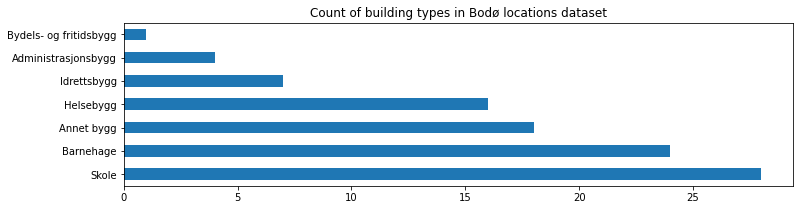

,location,location_type,building_type,address,latitude,longitude
0,Mørkvedbukta skole og barnehage,Bygning,Skole,Mørkvedbukta 38,67.279126,14.565775
1,ELBIL-LADERE BODØ,Bygning,Annet bygg,Kongens gate 23,67.283375,14.382744
2,Vatnlia Leirskole,Bygning,Skole,Vatnlia 42,67.349494,14.769497
3,Misvær Nye Barnehage,Bygning,Barnehage,Nupveien 35,67.121826,15.008112
4,Kvartal 99 Bygarasje,Bygning,Annet bygg,Prinsens gate 100,67.280438,14.376390


In [149]:
df_locations_bodo = pd.read_csv(f'{URL}locations_bodo.csv', sep=';', encoding='utf-8')
del df_locations_bodo['municipality_code']

title = 'Count of building types in Bodø locations dataset'
print(title)
print(df_locations_bodo.building_type.value_counts())
df_locations_bodo.head()

_, ax = plt.subplots(1, 1, figsize=(12, 3))
df_locations_bodo.building_type.value_counts().plot(kind='barh', ax=ax).set_title(title)
plt.show()
df_locations_bodo.head()

In [150]:
# TODO: Map overlay?
# sns.scatterplot(x='longitude', y='latitude', hue='building_type', data=df_locations_bodo)
# plt.show()

In [151]:
# Merge Bodø datasets

df_total = df_locations_bodo.merge(df_location_measurement_points_bodo, on='location', how='inner')
df_total.head(n=3)

,location,location_type,building_type,address,latitude,longitude,municipality_code,meter_id,meter_name
0,Mørkvedbukta skole og barnehage,Bygning,Skole,Mørkvedbukta 38,67.279126,14.565775,1804,Eklima_82290_TAM,Temp middel
1,ELBIL-LADERE BODØ,Bygning,Annet bygg,Kongens gate 23,67.283375,14.382744,1804,EID_972418013_00290,Hålogalandsgata 131
2,ELBIL-LADERE BODØ,Bygning,Annet bygg,Kongens gate 23,67.283375,14.382744,1804,EID_972418013_00315,Furumoen Sykehjem


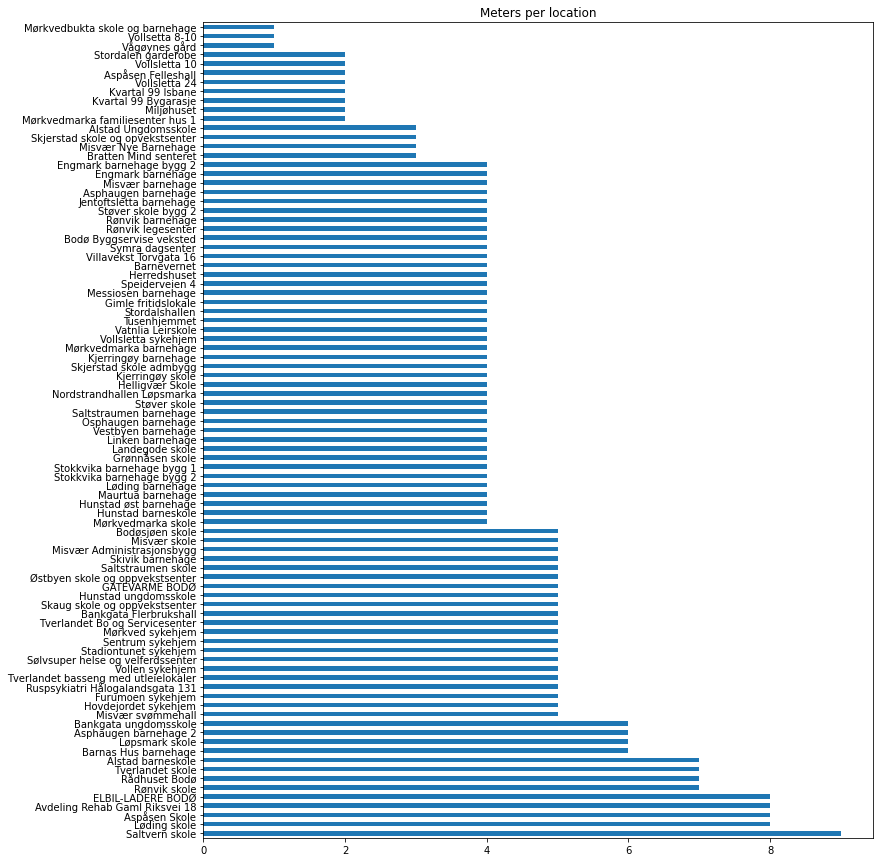

In [152]:
_, ax = plt.subplots(1, 1, figsize=(12, 15))
df_total.location.value_counts().plot(kind='barh', ax=ax).set_title('Meters per location')
plt.show()

In [153]:
%%time 

# The header row (column names) is located in row 4, so we can use the 'header' parameter (row - 1)
# to indicate that we want row 4 (use 3 as value) in the file to be the header row rather than the default (row 1)

df = pd.read_csv(f'{URL}Gulskogen%20skole.csv', sep=';', encoding='iso-8859-1', header=3,
                usecols=lambda x: 'Unnamed' not in str(x))

# Fix columns
df['Utetemperatur - grader'] = df['Utetemperatur - grader'].map(lambda x: x.replace(',', '.')) 
df['Utetemperatur - grader'] = df['Utetemperatur - grader'].astype(float)
df['Tid (Time)'] = df['Tid (Time)'].map(lambda x: x[:16]) 
df['Tid (Time)'] = pd.to_datetime(df['Tid (Time)'])
print(df.shape)
print(df.describe())
df.head(n=2)

(8760, 4)
       El-014456308- Hovedmåler KWh  El-18815788- El-kjel - KWh  \
count                   8760.000000                 8760.000000   
mean                      62.622717                   62.928995   
std                       48.607496                   61.325621   
min                       11.000000                    0.000000   
25%                       32.000000                    5.000000   
50%                       43.000000                   44.000000   
75%                       70.000000                  105.000000   
max                      255.000000                  263.000000   

       Utetemperatur - grader  
count             8760.000000  
mean                 8.282233  
std                 11.915839  
min                -17.700000  
25%                  0.210000  
50%                  8.100000  
75%                 15.742500  
max                 56.110000  
Wall time: 1.24 s


,Tid (Time),El-014456308- Hovedmåler KWh,El-18815788- El-kjel - KWh,Utetemperatur - grader
0,2021-01-01 00:00:00,41,95,0.2
1,2021-01-01 01:00:00,40,97,0.2


Tid (Time)                      datetime64[ns]
El-014456308- Hovedmåler KWh             int64
El-18815788- El-kjel - KWh               int64
Utetemperatur - grader                 float64
dtype: object
[ 0.21    8.1    15.7425 56.11  ]


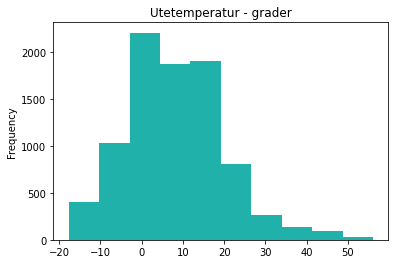

In [154]:
# Visualize the dataset, create a historgram to show temperature distribution

print(df.dtypes)
print(np.quantile(df['Utetemperatur - grader'], q=[.25, .5, .75, 1])) # Some very high outdoor temperatures here
df['Utetemperatur - grader'].plot(kind='hist', color='lightseagreen').set_title('Utetemperatur - grader')
plt.show()

In [155]:
%%time

df = pd.read_csv(f'{URL}measurement_stavanger.csv', encoding='iso-8859-1', sep=';', header=0)
print(df.shape)
df = df.drop(0) # Drop the 'dateUnit' row
df.rename(columns={'Unnamed: 0':'Tidspunkt'}, inplace=True) # Change name of first column
# Fix datatypes, etc. in some columns
for col in ['Radon', 'Radon.1', 'Radon.2', 'Temperatur']:
    df[col].fillna('0', inplace=True)
    df[col] = df[col].map(lambda x: x.replace(',', '.'))
    df[col] = df[col].astype(float)                

df['Tidspunkt'] = pd.to_datetime(df['Tidspunkt']) # Change datatype on the timestamp column from string to datetime
df.head(n=2)

(8688, 25)
Wall time: 1.29 s


,Tidspunkt,Fastkraft,Varmepumpe 1 EL tilført,Varmepumpe 1 avgitt energi,Varmepumpe 2 EL tilført,Varmepumpe 2 avgitt energi,Varmevannsbereder EL,Elektrokjel spisslast,EL vifter,Varme ventilasjon,...,Varme ventilasjon.3,EL vifter.4,Varme ventilasjon.4,Varme radiator,Varme gulv,Radon,Radon.1,Radon.2,Areal,Temperatur
1,2021-01-01 00:00:00,31,1,0,14,38,5,0,0,0,...,0,0,0,30,5,971.0,1018.2,676.0,5678,2.6
2,2021-01-01 01:00:00,31,1,0,14,37,5,0,0,0,...,0,0,0,20,12,897.7,1043.6,789.2,5678,2.7


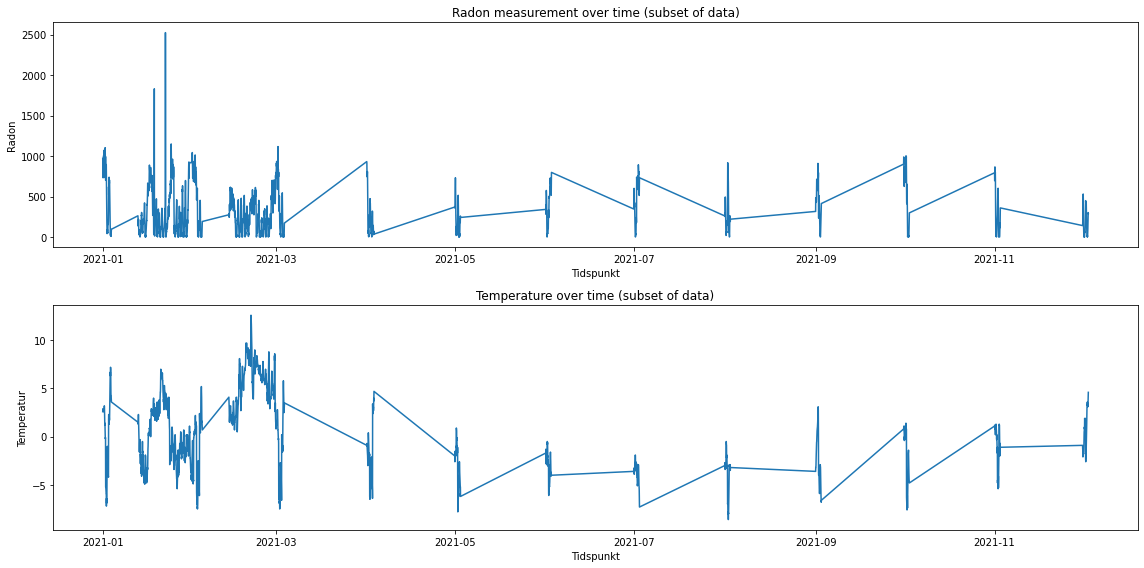

In [156]:
# Visualize a subset of radon and temperature data

n = 1500
_, ax = plt.subplots(2, 1, figsize=(16, 8))
sns.lineplot(x='Tidspunkt', y='Radon', data=df[:n], ax=ax[0]).set_title('Radon measurement over time (subset of data)')
sns.lineplot(x='Tidspunkt', y='Temperatur', data=df[:n], ax=ax[1]).set_title('Temperature over time (subset of data)')
plt.tight_layout()
plt.show()

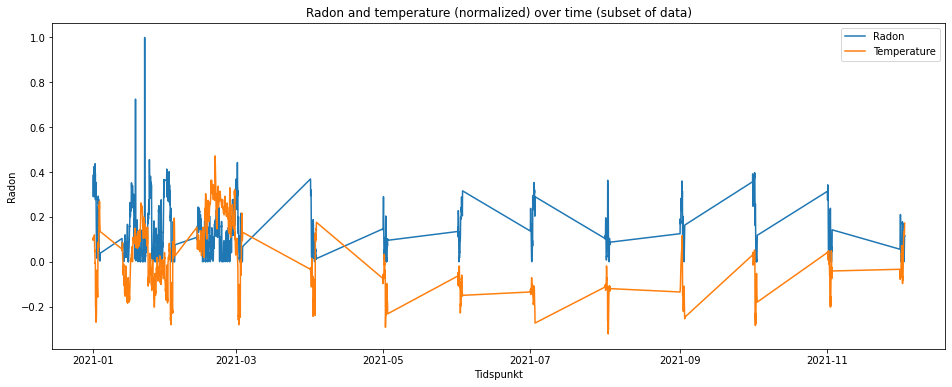

In [157]:
# Scale/normalize the temperature and radon columns, so we can plot both series on top of each other within same value range

def absolute_maximum_scale(series):
    return series / series.abs().max()

for col in ['Radon', 'Temperatur']:
    df[col] = absolute_maximum_scale(df[col])

_, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.lineplot(x='Tidspunkt', y='Radon', data=df[:n],
             ax=ax, label='Radon').set_title('Radon and temperature (normalized) over time (subset of data)')
sns.lineplot(x='Tidspunkt', y='Temperatur', data=df[:n], ax=ax, label='Temperature')
ax.legend()
plt.show()

In [158]:
# Test DataLake REST API, get raw CSV text with the 'requests' library

resp = requests.get(f'{URL}location_measurement_points_bodo.csv')
resp.text[0:200]

'location;municipality_code;meter_id;meter_name\r\nMørkvedbukta skole og barnehage;1804;Eklima_82290_TAM;Temp middel\r\nELBIL-LADERE BODØ;1804;EID_972418013_00290;Hålogalandsgata 131\r\nELBIL-LADERE BODØ;180'

In [159]:
# Test DataLake REST API backend (FastAPI, localhost)
# df = pd.read_csv('http://localhost:8000/datasets/locations_bodo.csv', sep=';')
# Test DataLake REST API backend (FastAPI, Azure DataLake)

filename = 'locations_bodooo.csv'

df = pd.read_csv(f'{URL}{filename}', sep=';')

print(df.shape)
df.head()

(0, 1)


,"{""status_code"":404,""detail"":""File 'locations_bodooo.csv' does not exist."",""headers"":null}"


In [160]:
# Try reading a JSON file with Pandas read_json
# df = pd.read_json('http://localhost:8000/datasets/PublicSheltersNorway.json')
# df
# Try reading a JSON file from Azure Data Lake with Pandas read_json
df = pd.read_json(f'{URL}PublicSheltersNorway.json')
df

,features,type
0,{'geometry': {'coordinates': [9.21489025600826...,FeatureCollection
1,{'geometry': {'coordinates': [9.90855680938451...,FeatureCollection
2,{'geometry': {'coordinates': [9.62722810179604...,FeatureCollection
3,{'geometry': {'coordinates': [9.65179710841463...,FeatureCollection
4,{'geometry': {'coordinates': [9.64739684901480...,FeatureCollection
...,...,...
311,{'geometry': {'coordinates': [10.3568367515447...,FeatureCollection
312,{'geometry': {'coordinates': [10.4410750414276...,FeatureCollection
313,{'geometry': {'coordinates': [10.4050949119499...,FeatureCollection
314,{'geometry': {'coordinates': [11.1699121729406...,FeatureCollection


In [161]:
# Try reading a JSON file with requests
resp = requests.get(f'{URL}PublicSheltersNorway.json')
json.loads(resp.text)

{'features': [{'geometry': {'coordinates': [9.214890256008264,
     58.714427371009855],
    'type': 'Point'},
   'properties': {'adresse': 'Idrettshall - Kjempesteinsmyra',
    'gnr': 15,
    'bnr': 1,
    'kommunenr': 901,
    'areal': 144,
    'byggear': 1990,
    'kategori': '76-Rom B',
    'kommune': 'RISØR',
    'distriktsnavn': 'Aust-Agder SFD',
    'plasser': 240,
    'romtype': 'Offentlig'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [9.908556809384518, 59.77097311352049],
    'type': 'Point'},
   'properties': {'adresse': 'Stasjonsgata 24',
    'gnr': 77,
    'bnr': 89,
    'kommunenr': 624,
    'areal': 347,
    'byggear': 1972,
    'kategori': '66-Rom',
    'kommune': 'ØVRE EIKER',
    'distriktsnavn': 'Buskerud SFD',
    'plasser': 385,
    'romtype': 'Offentlig'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [9.62722810179604, 59.68217953673361],
    'type': 'Point'},
   'properties': {'adresse': 'Dyrgravveien 5',
    'gnr': 7719,
    'bnr': 31,
    'k

### Test downloading a JSON file (shown in separate browser tab)
<a href='https://datafabrikken-v2-api.azurewebsites.net/datasets/PublicSheltersNorway.json'>Download JSON</a>

In [162]:
%%time

# Example of reading Excel file

df = pd.read_excel(f'{URL}00%20-%20Bygg%20og%20GPS.xlsx',
                   engine='openpyxl', # Approx. cuts download time in half
                   index_col=None,
                   header=1, # Zero-based index, so data starts in rows 2 in the Excel sheet
                   usecols=lambda x: 'Unnamed' not in str(x))
print(df.shape)
df.head()

(98, 7)
Wall time: 230 ms


,Nr,Bygg,North,East,Adresse,Postnr,Sted
0,1,Mørkvedbukta skole og barnehage,67.279126,14.565775,Mørkvedbukta 38,8020,Bodø
1,2,ELBIL-LADERE BODØ,67.283375,14.382744,Kongens gate 23,8006,Bodø
2,3,Vatnlia Leirskole,67.349494,14.769497,Vatnlia 42,8050,Tverlandet
3,4,Misvær Nye Barnehage,67.121826,15.008112,Sekundær Fylkesveg 552 76,8100,Misvær
4,5,Kvartal 99 Bygarasje,67.280438,14.376390,Prinsens gate 100,8005,Bodø
